
# Reinforcement Learning and Self-Driving
## AMS 691 Project final report

### Introduction

This report shows how to use reinforcement learning algorithems(DQN, PPO with attention) to train a agent
on the Highway-v0 task from [HighwayEnv](https://github.com/Farama-Foundation/HighwayEnv).

**Task**
In this task, the ego-vehicle agent is driving on a multilane highway populated with other vehicles. The agent's objective is to reach a high speed while avoiding collisions with neighbouring vehicles. Driving on the right side of the road is also rewarded. You can find more
information about the environment and other more challenging environments at
[Documentation's website](https://highway-env.farama.org/environments/highway/).

![highway](Highway-demo.gif)

**Packages**


First, let's import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/) for the environment,
installed by using pip. 


In [1]:
# %%bash
# !pip install highway-env
# !pip install stable_baselines3

**Making an environment**

/Users/ylpan/anaconda3/envs/yl_RL_Project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


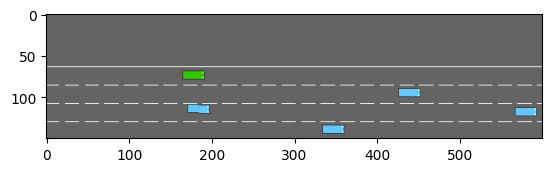

In [4]:
import gymnasium as gym
from matplotlib import pyplot as plt
%matplotlib inline

env = gym.make('highway-v0', render_mode='rgb_array')
env.reset()
for _ in range(3):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.show()
env.close()

**Configuring an environment**

The observations, actions, dynamics and rewards of an environment are parametrized by a configuration, defined as a ``config`` dictionary. After environment creation, the configuration can be accessed using the ``config`` attribute.

In [5]:
import pprint

env = gym.make("highway-v0", render_mode='rgb_array')
pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


/Users/ylpan/anaconda3/envs/yl_RL_Project/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


### DQN algorithm

Our environment is deterministic, so all equations presented here are also formulated deterministically for the sake of simplicity. In the reinforcement learning literature, they would also contain expectations over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted, cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$ is also known as the *return*. The discount, $\gamma$, should be a constant between $0$ and $1$ that ensures the sum converges. A lower $\gamma$ makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about. It also encourages agents to collect reward closer in time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function $Q^*: State \times Action \rightarrow \mathbb{R}$, that could tellus what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have access to $Q^*$. But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^*$. 

For our training update rule, we'll use a fact that every $Q$ function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimize this error, we will use the Huber loss. The Huber loss acts like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to outliers when the estimates of $Q$ are very noisy. We calculate this over a batch of transitions, $B$, sampled from the replay memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### DQN Training

Reinforcement Learning agents can be trained using libraries such as eleurent/rl-agents, openai/baselines or Stable Baselines3. Here is an example of SB3’s DQN implementation trained on highway-fast-v0 with its default kinematics observation and an MLP model.

In [ ]:
import gymnasium as gym
import highway_env
from stable_baselines3 import DQN

env = gym.make("highway-fast-v0")
model = DQN('MlpPolicy', env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/")
model.learn(int(2e4))
model.save("highway_dqn/model")

# Load and test saved model
model = DQN.load("highway_dqn/model")
# while True:
for _ in range(1):
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
  env.close()

### DQN Result

The following results are obtained:

![DQN](yl_DQN_Result.jpg)



### PPO algorithm

Proximal Policy Optimization (PPO) is a policy-gradient algorithm where a batch of data is being collected and directly consumed to train the policy to maximise the expected return given some proximality constraints. You can think of it as a sophisticated version of statistical gradient-following algorithms, the foundational policy-optimization algorithm. For more information, see the Proximal Policy Optimization Algorithms paper.

PPO is usually regarded as a fast and efficient method for online, on-policy reinforcement algorithm. For completeness, here is a brief overview of what the loss computes, the precise formula of the loss is:

\begin{align}L(s,a,\theta_k,\theta) = \min\left(
    \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
    g(\epsilon, A^{\pi_{\theta_k}}(s,a))
    \right),\end{align}

There are two components in that loss: in the first part of the minimum operator, we simply compute an importance-weighted version of the REINFORCE loss (for example, a REINFORCE loss that we have corrected for the fact that the current policy configuration lags the one that was used for the data collection). The second part of that minimum operator is a similar loss where we have clipped the ratios when they exceeded or were below a given pair of thresholds.

This loss ensures that whether the advantage is positive or negative, policy updates that would produce significant shifts from the previous configuration are being discouraged.

**Attention**

Attention architecture also is considered. Out of a complex scene description, the model should be able to filter information and consider only
what is relevant for decision. In other words, the agent should pay attention to vehicles that are close
or conflict with the planned route. It is composed of a first linear encoding layer whose weights are shared between all vehicles. It
obtains a stochastic matrix called the attention matrix, which is finally used to gather a set of output value $V = [v_0, ..., v_N]$. Overall, the attention computation for each head can be written as:
$$output = \sigma (\frac{QK^T}{\sqrt{d_k}})V$$
The outputs from all heads are finally combined with a linear layer, and the resulting tensor is then
added to the ego encoding as in residual networks.

### PPO Training

I include the training code part in Appendix.

### PPO Result

![PPO](yl_PPO_Attention_Result.jpg)



### Conclusion

In this reinforcement learning project, we applied two distinct methods, Deep Q-Network (DQN) and attention-based Proximal Policy Optimization (PPO), to train an agent in the challenging highway scenarios simulated by the highway-env environment. These methods aimed to create a more adaptable and robust autonomous agent. The attention-based PPO method exhibited notable characteristics, showcasing quick convergence and consistently high mean rewards. This underscored its proficiency to filter information and consider only what is relevant for decision. The agent trained using attention-based PPO exhibited stable behavior. The agent, trained through attention-based PPO, displayed stability in its task.

While our results are promising, there remain opportunities for further exploration and enhancement. Future work could focus on multi-agent situations. What we did so far only mimic the human driver and tried to train an agent who had the driving ability as the best human driver. But it's far more enough as we expected. Additionally, investigating a system that can share the environment and reward information may provide deeper insights into the agent's behavior.

In conclusion, our reinforcement learning project demonstrated the effectiveness of two methods. The successful training of an adaptive agent in highway scenarios opens avenues for continued research and development in autonomous vehicle navigation.

### Reference

1. Rana A, Malhi A. Building safer autonomous agents by leveraging risky driving behavior knowledge. In2021 International Conference on Communications, Computing, Cybersecurity, and Informatics (CCCI) 2021 Oct 15 (pp. 1-6). IEEE.

2. S. Zhang, L. Wen, H. Peng and H. E. Tseng, "Quick Learner Automated Vehicle Adapting its Roadmanship to Varying Traffic Cultures with Meta Reinforcement Learning," 2021 IEEE International Intelligent Transportation Systems Conference (ITSC), Indianapolis, IN, USA, 2021, pp. 1745-1752, doi: 10.1109/ITSC48978.2021.9564972.
3. Brito B, Agarwal A, Alonso-Mora J. Learning interaction-aware guidance policies for motion planning in dense traffic scenarios. arXiv preprint arXiv:2107.04538. 2021 Jul 9.

4. X. Chen, J. Wei, X. Ren, K. H. Johansson and X. Wang, "Automatic Overtaking on Two-way Roads with Vehicle Interactions Based on Proximal Policy Optimization," 2021 IEEE Intelligent Vehicles Symposium (IV), Nagoya, Japan, 2021, pp. 1057-1064, doi: 10.1109/IV48863.2021.9575954.

5. Schott L, Hajri H, Lamprier S. Improving Robustness of Deep Reinforcement Learning Agents: Environment Attack based on the Critic Network. In2022 International Joint Conference on Neural Networks (IJCNN) 2022 Jul 18 (pp. 1-8). IEEE.

6. Liu Q, Dang F, Wang X, Ren X. Autonomous highway merging in mixed traffic using reinforcement learning and motion predictive safety controller. In2022 IEEE 25th International Conference on Intelligent Transportation Systems (ITSC) 2022 Oct 8 (pp. 1063-1069). IEEE.

7. Leurent E. Safe and Efficient Reinforcement Learning for Behavioural Planning in Autonomous Driving In2020 

8. Lazzaroni, L., Bellotti, F., Capello, A., Cossu, M., De Gloria, A., Berta, R. (2023). Deep Reinforcement Learning for Automated Car Parking. In: Berta, R., De Gloria, A. (eds) Applications in Electronics Pervading Industry, Environment and Society. ApplePies 2022. Lecture Notes in Electrical Engineering, vol 1036. Springer, Cham. https://doi.org/10.1007/978-3-031-30333-3_16

9. Leurent E, Mercat J. Social attention for autonomous decision-making in dense traffic. arXiv preprint arXiv:1911.12250. 2019 Nov 27.

10. Zhang, H., Chen, W., Huang, Z., Li, M., Yang, Y., Zhang, W., & Wang, J. (2020). Bi-Level Actor-Critic for Multi-Agent Coordination. Proceedings of the AAAI Conference on Artificial Intelligence, 34(05), 7325-7332. https://doi.org/10.1609/aaai.v34i05.6226

11. Sriram NN, Liu B, Pittaluga F, Chandraker M. Smart: Simultaneous multi-agent recurrent trajectory prediction. InComputer Vision–ECCV 2020: 16th European Conference, Glasgow, UK, August 23–28, 2020, Proceedings, Part XXVII 16 2020 (pp. 463-479). Springer International Publishing.

12. Chen B, Xu M, Liu Z, Li L, Zhao D. Delay-aware multi-agent reinforcement learning for cooperative and competitive environments. arXiv preprint arXiv:2005.05441. 2020 May 11.

13. Williams, R.J. Simple statistical gradient-following algorithms for connectionist reinforcement learning. Mach Learn 8, 229–256 (1992). https://doi.org/10.1007/BF00992696

14. Schulman J, Wolski F, Dhariwal P, Radford A, Klimov O. Proximal policy optimization algorithms. arXiv preprint arXiv:1707.06347. 2017 Jul 20.
